      Dataset :: Combined Healthy Abdominal Organ Segmentation (CHAOS) Challenge
      Source  :: https://chaos.grand-challenge.org/Combined_Healthy_Abdominal_Organ_Segmentation/

      Modified  :: SAR2020
      Train   :: 18 CTs
      Test    :: 2 CTs

**References to the original dataset and related publications:**

> <sub><sup>A.E. Kavur, M. A. Selver, O. Dicle, M. Barış,  N.S. Gezer. CHAOS - Combined (CT-MR) Healthy Abdominal Organ Segmentation Challenge Data (Version v1.03) [Data set]. Apr.  2019. Zenodo. http://doi.org/10.5281/zenodo.3362844 </sup></sub>

> <sub><sup>A.E. Kavur, N.S. Gezer, M. Barış, P.-H. Conze, V. Groza, D.D. Pham, et al. "CHAOS Challenge - Combined (CT-MR) Healthy Abdominal Organ Segmentation", arXiv pre-print, Jan. 2020. https://arxiv.org/abs/2001.06535</sup></sub>

> <sub><sup>A.E. Kavur, N.S. Gezer, M. Barış, Y.Şahin, S. Özkan, B. Baydar, et al.  "Comparison of semi-automatic and deep learning-based automatic methods for liver segmentation in living liver transplant donors", Diagnostic and  Interventional  Radiology,  vol. 26, pp. 11–21, Jan. 2020. https://doi.org/10.5152/dir.2019.19025</sup></sub>

### Installation

In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
!pip install pydicom

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 5.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=9998979219b2c19191422ae75d2dd09c8c6e9ae8f8f71090eba868889c3217d7
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-0uqxblue
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-0uqxblue
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [0]:
import torch
import torchvision
import detectron2

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils

from detectron2.utils.logger import setup_logger
setup_logger()

import os
import cv2
import json
import copy
import random
import pydicom
import pycocotools
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  from google.colab.patches import cv2_imshow as imshow
else:
  from matplotlib.pyplot import imshow
  %matplotlib inline

In [0]:
# # original dataset
# !wget -q https://zenodo.org/record/3431873/files/CHAOS_Train_Sets.zip
# !wget -q https://zenodo.org/record/3431873/files/CHAOS_Test_Sets.zip

# !unzip -q CHAOS_Train_Sets.zip
# !unzip -q CHAOS_Test_Sets.zip

# !rm -rf CHAOS_Train_Sets.zip
# !rm -rf CHAOS_Test_Sets.zip

In [0]:
# sar2020 modified dataset
!wget -q https://www.dropbox.com/s/ajg922tunqptd2z/chaos_train.zip
!unzip -q chaos_train.zip
!rm -rf chaos_train.zip

In [0]:
!rm -rf ./__MACOSX
!rm -rf ./sample_data

In [0]:
ROOT_PATH = Path('/content')
chaos_dir = ROOT_PATH/'chaos_train'
ct_dir    = chaos_dir/'CT'

# Prepare the dataset

In [0]:
dicoms_train = []
segs_train   = []
dicoms_val   = []
segs_val     = []

In [0]:
cts = [x for x in ct_dir.iterdir() if x.is_dir()]

random.seed(21)
random.shuffle(cts)

train_cts = cts[:18]
val_cts = cts[18:]

In [9]:
train_cts[:3]

[PosixPath('/content/chaos_train/CT/22'),
 PosixPath('/content/chaos_train/CT/25'),
 PosixPath('/content/chaos_train/CT/5')]

In [0]:
for p in train_cts:
  dicoms_train += sorted([x for x in (p/'DICOM_anon').iterdir() if x.is_file()])
  segs_train += sorted([x for x in (p/'Ground').iterdir() if x.is_file()])

for p in val_cts:
  dicoms_val += sorted([x for x in (p/'DICOM_anon').iterdir() if x.is_file()])
  segs_val += sorted([x for x in (p/'Ground').iterdir() if x.is_file()])

In [11]:
len(dicoms_train), len(segs_train), len(dicoms_val), len(segs_val)

(2377, 2377, 497, 497)

In [0]:
def mapper(dataset_dict):
  """
  Args:
      dataset_dict (dict): Metadata of one image, in detectron2 Dataset format.

  Returns:
      dict: a format that builtin models in detectron2 accept
  """
  # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
  dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
  ds = pydicom.dcmread(dataset_dict["file_name"])
  image = ds.pixel_array
  
  # Convert pixel values to Hounsfield units
  image = image*ds.RescaleSlope + ds.RescaleIntercept
  image, transforms = T.apply_transform_gens([T.RandomBrightness(0.8, 1.2), T.RandomContrast(0.8, 1.2)], image)
  dataset_dict["image"] = torch.as_tensor(image.astype("float32"))

  annos = [
      utils.transform_instance_annotations(obj, transforms, image.shape[:2])
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
  ]
  instances = utils.annotations_to_instances(annos, image.shape[:2], mask_format='bitmask')
  dataset_dict["instances"] = utils.filter_empty_instances(instances)
  return dataset_dict

class LiverTrainer(DefaultTrainer):
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=mapper)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)

def load_mask(image_path):
    """Load masks for the given image.
    Mask is a binary true/false map of the same size as the image.
    args:
      image_path = complete path to segmentation file
    returns:
      boolean array of the liver segmentation mask 
    """
    mask = plt.imread(str(image_path))
    return mask.astype(np.bool)

def bbox(img):
    """Generates a bounding box from a segmentation mask
    Bounding box is given as coordinates of upper left and lower right corner
    args:
      img = boolean array of a segmentation mask
    returns:
      coordinates of upper left and lower right corner 
    """
    try:
      x,y = np.where(img)
    except ValueError:
      return None
    if x.size != 0:
      bbox = y.min(), x.min(), y.max(), x.max()
    else:
      bbox = None
    return bbox

def windowed(px, w, l):
    """Windows a pixel_array of Houndfield units
    args:
      px = pixel array in Houndfield units
      w = window width (HU range)
      l = window level (center point)
    returns:
      pixel_array convered to the given window/level
    """
    if type(w) == pydicom.multival.MultiValue:
      w = w[0]
    if type(l) == pydicom.multival.MultiValue:
      l = l[0]
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

def get_liver_dicts(train_or_val):
  """Builds a dataset_dict for detectron2
    args:
      train_or_val = string 'train' or 'val' indicating whether to return
        the training or validation dataset_dict
    returns:
      dataset_dict with each element of the training or validation dataset
    """
  if train_or_val == "train":
    dicoms = dicoms_train
    segs = segs_train
  elif train_or_val == "val":
    dicoms = dicoms_val
    segs = segs_val

  dataset_dicts = []
  for idx, v in enumerate(dicoms):
    record = {}
    
    filename = str(v)
    ds = pydicom.dcmread(filename)
    height, width = ds.Rows, ds.Columns

    # Mininum required fields for each element in the dict
    record["file_name"] = filename  # Full path to image file
    record["image_id"] = idx        # Index of file (unique serial number)
    record["height"] = height       # Image dimension
    record["width"] = width         # Image dimension

    try:
      mask = load_mask(str(segs[idx]))
    except IndexError:
      mask = None

    # Add list of segmentation object(s)
    objs = []
    if bbox(mask) is not None:
      obj = {
          "bbox": bbox(mask),
          "bbox_mode": BoxMode.XYXY_ABS,
          "segmentation": pycocotools.mask.encode(np.asarray(mask, order="F")), # Convert binary mask to RLE format
          "category_id": 0,
          "is_crowd": 0
      }
      objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [0]:
# Clear existing DatasetCatalog and then register the training and validation datasets
DatasetCatalog.clear()  
for d in ["train", "val"]:
    DatasetCatalog.register("liver_" + d, lambda d=d: get_liver_dicts(d))
    MetadataCatalog.get("liver_" + d).set(thing_classes=["liver"])
liver_metadata = MetadataCatalog.get("liver_train")

# Verify Data Loading
To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [0]:
dataset_dicts = get_liver_dicts("train")

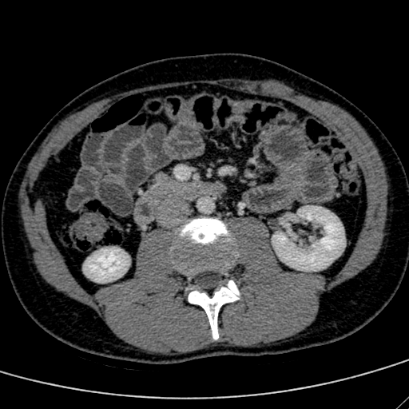

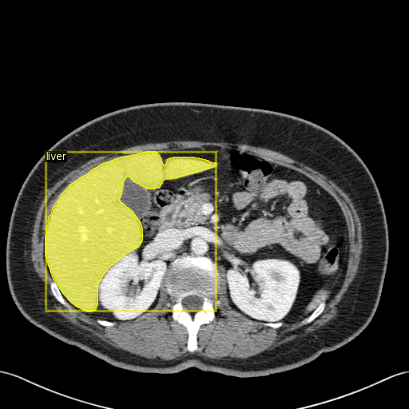

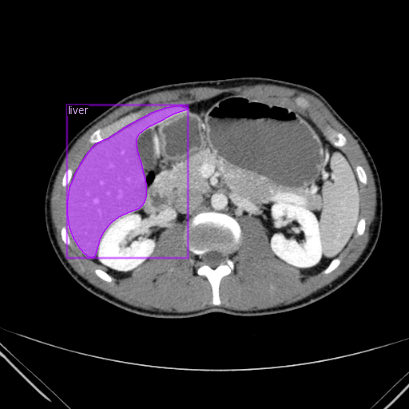

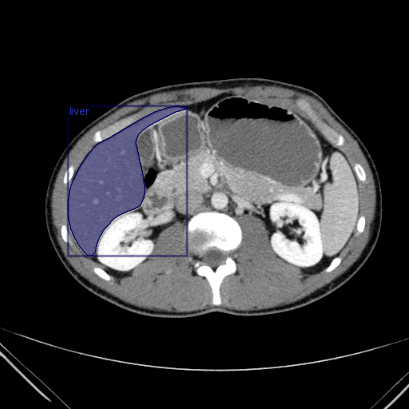

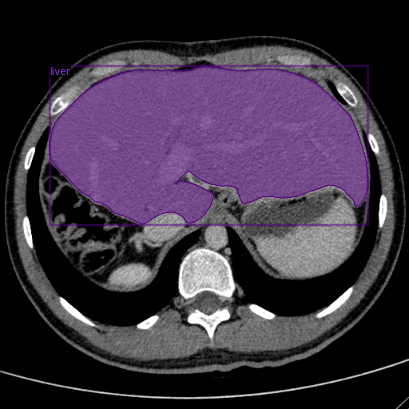

In [15]:
for d in random.sample(dataset_dicts, 5):
    ds=pydicom.dcmread(d["file_name"])
    im=ds.pixel_array
    im=im*ds.RescaleSlope + ds.RescaleIntercept
    im = windowed(im, ds.WindowWidth, ds.WindowCenter)
    im = np.stack((im,) * 3, -1)
    im=im*255
    v = Visualizer(im[:, :, ::-1],
                   metadata=liver_metadata, 
                   scale=0.8
    )
    v = v.draw_dataset_dict(d)
    imshow(v.get_image()[:, :, ::-1])

# Train

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the liver dataset. It takes ~2 minutes to train 300 iterations on Colab.


In [16]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("liver_train",)
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

# These three SOLVER parameters are probably the best places to start tweaking to modify performance
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.001  # Can experiment with differnt base learning rates
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this simple dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (liver)

cfg.INPUT.FORMAT = "F" #32-bit single channel floating point pixels
cfg.INPUT.MASK_FORMAT = "bitmask" # Needed to change this from the default "polygons"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = LiverTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/01 16:14:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:17, 9.90MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/01 16:15:21 d2.engine.train_loop]: Starting training from iteration 0
[06/01 16:15:51 d2.utils.events]:  eta: 0:12:21  iter: 19  total_loss: 1.767  loss_cls: 0.815  loss_box_reg: 0.231  loss_mask: 0.697  loss_rpn_cls: 0.031  loss_rpn_loc: 0.006  time: 1.5396  data_time: 0.0608  lr: 0.000020  max_mem: 3277M
[06/01 16:16:22 d2.utils.events]:  eta: 0:11:51  iter: 39  total_loss: 1.313  loss_cls: 0.291  loss_box_reg: 0.292  loss_mask: 0.678  loss_rpn_cls: 0.028  loss_rpn_loc: 0.006  time: 1.5448  data_time: 0.0551  lr: 0.000040  max_mem: 3277M
[06/01 16:16:54 d2.utils.events]:  eta: 0:11:26  iter: 59  total_loss: 1.291  loss_cls: 0.239  loss_box_reg: 0.378  loss_mask: 0.631  loss_rpn_cls: 0.015  loss_rpn_loc: 0.006  time: 1.5554  data_time: 0.0564  lr: 0.000060  max_mem: 3277M
[06/01 16:17:25 d2.utils.events]:  eta: 0:10:56  iter: 79  total_loss: 1.153  loss_cls: 0.185  loss_box_reg: 0.397  loss_mask: 0.576  loss_rpn_cls: 0.014  loss_rpn_loc: 0.005  time: 1.5601  data_time: 0.0574  lr:

In [0]:
# Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output
# %reload_ext tensorboard

# Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

class LiverPredictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.
    Compared to using the model directly, this class does the following additions:
    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.
    If you'd like to do anything more fancy, please refer to its source code
    as examples to build and use the model manually.
    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.
    Examples:
    .. code-block:: python
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfg):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = build_model(self.cfg)
        self.model.eval()
        self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        
    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): a single channel image.
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            height, width = original_image.shape[:2]
            image = original_image
            image = torch.as_tensor(image.astype("float32"))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("liver_val", )
predictor = LiverPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

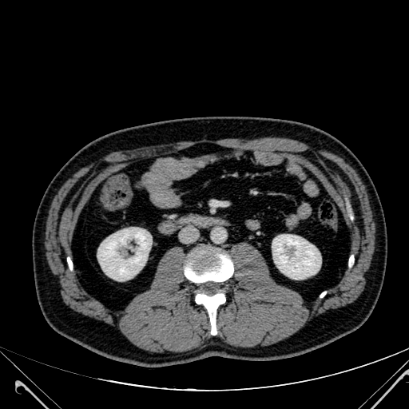

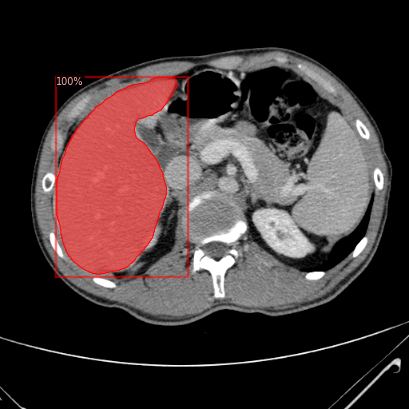

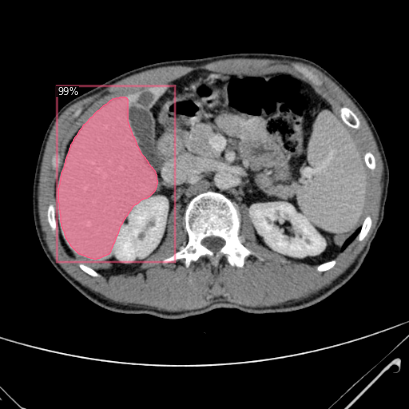

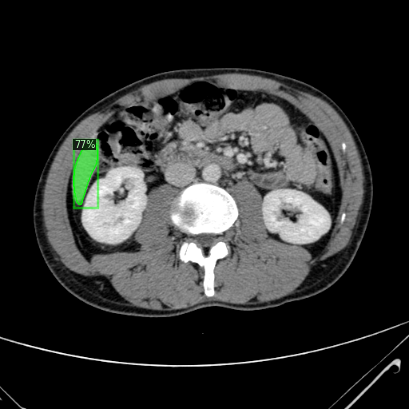

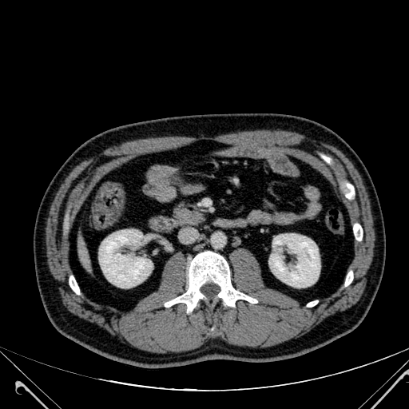

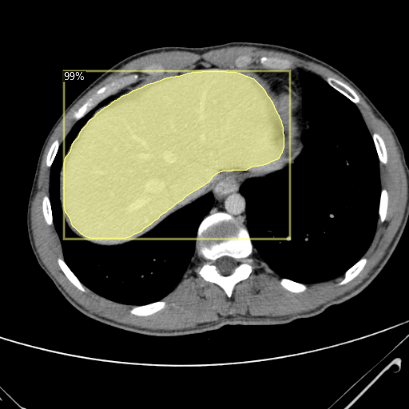

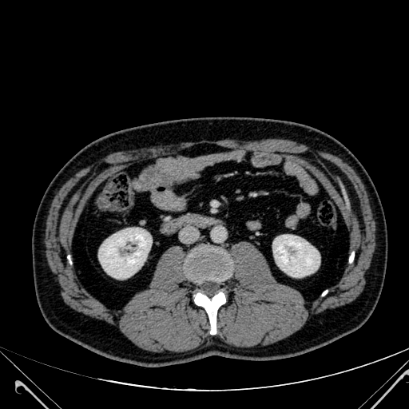

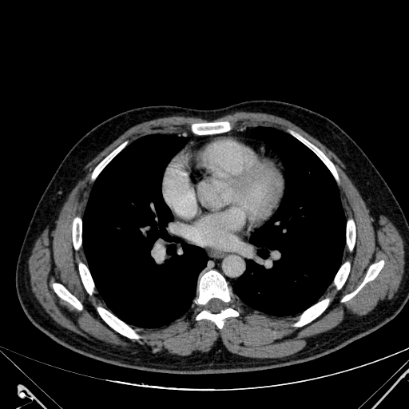

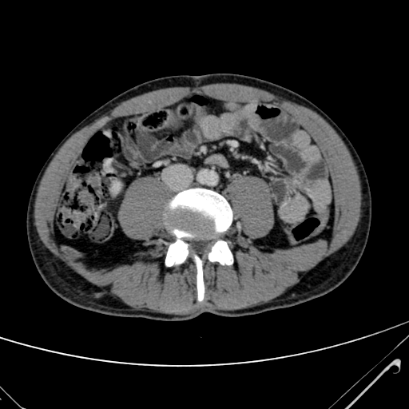

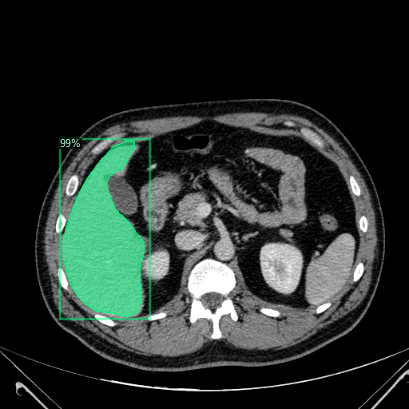

In [20]:
dataset_dicts = get_liver_dicts("val")
for d in random.sample(dataset_dicts, 10): 
    ds=pydicom.dcmread(d["file_name"])
    im=ds.pixel_array
    im=im*ds.RescaleSlope + ds.RescaleIntercept
    outputs = predictor(im)
    im = windowed(im, ds.WindowWidth, ds.WindowCenter)
    im = np.stack((im,) * 3, -1)
    im=im*255
    v = Visualizer(im[:, :, ::-1],
                   metadata=liver_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(v.get_image()[:, :, ::-1])

### Save Model to Drive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mv output/model_final.pth output/chaos_ct_liver_segmentation.pth
!cp output/chaos_ct_liver_segmentation.pth 'drive/My Drive/__models__/'

!mv output/metrics.json output/chaos_ct_liver_segmentation_train_metrics.json
!cp output/chaos_ct_liver_segmentation_train_metrics.json 'drive/My Drive/__models__/'